(seb:solution)=
### Surface Energy Balance model

The aim of this exercise is to understand how we can solve simple optimisation problems. To do this, we will develop a simple surface energy balance model (SEB). Since energy can neither be produced nor destroyed, the sum of the energy fluxes at the Earth's surface must be zero. If the static quantities such as roughness length, albedo, stability etc. are known and quantities such as temperature and humidity are measured, the balance of the energy fluxes at the surface is only a function of the surface temperature.

For simplicity, we parameterise the turbulent fluxes with a bulk approach and neglect the soil heat flux. However, at the end of this exercise, we will consider the soil heat flux by coupling the heat conduction equation to the energy balance model.

**Task 1**: Develop a simple SEB model. The turbulent flows are to be parameterised using a simple bulk approach. Write a function that takes the following arguments: surface temperature, air temperature, relative humidity, albedo, global radiation, atmospheric pressure, air density, wind speed, altitude measured and roughness length. The function should return the short-wave radiation balance and the two turbulent energy fluxes.

In [14]:
import math
import numpy as np
from scipy.optimize import minimize, minimize_scalar
import matplotlib.pyplot as plt

%matplotlib inline


def EB_fluxes(T_0,T_a,f,albedo,G,p,rho,U_L,z,z_0):
    """ This function calculates the energy fluxes from the following quantities:
    
    Input: 
    T_0       : Surface temperature, which is optimized [K]
    f         : Relative humdity as fraction, e.g. 0.7 [-]
    albedo    : Snow albedo [-]
    G         : Shortwave radiation [W m^-2]
    p         : Air pressure [hPa]
    rho       : Air denisty [kg m^-3]
    z         : Measurement height [m]
    z_0       : Roughness length [m]
    
    """
    
    # Some constants
    c_p = 1004.0      # specific heat [J kg^-1 K^-1]
    kappa = 0.40      # Von Karman constant [-]
    sigma = 5.67e-8   # Stefan-Bolzmann constant
    
    # Bulk coefficients 
    Cs_t = np.power(kappa,2.0) / ( np.log(z/z_0) * np.log(z/z_0) )
    Cs_q = np.power(kappa,2.0) / ( np.log(z/z_0) * np.log(z/z_0) )  
    
    # Correction factor for incoming longwave radiation
    T_atmos = 273.0
    eps_cs = 0.23 + 0.433 * np.power(100*(f*E_sat(T_atmos))/T_atmos,1.0/8.0)
    
    # Select the appropriate latent heat constant
    L = 2.83e6 # latent heat for sublimation

    # Calculate turbulent fluxes
    H_0 = rho * c_p  * Cs_t * U_L * (T_0-T_a)
    E_0 = rho * ((L*0.622)/p) * Cs_q * U_L * (E_sat(T_0)-f*E_sat(T_a))
    
    # Calculate radiation budget
    L_d = eps_cs * sigma * (T_atmos)**4
    L_u = 0.99 * sigma * (T_0)**4 
    Q_0 = (1-albedo)*G #+ L_d - L_u

    return (Q_0, L_d, L_u, H_0, E_0)

def E_sat(T):
    """ Saturation water vapor equation """
    Ew = 6.112 * np.exp((17.67*(T-273.16)) / ((T-29.66)))
    return Ew


In [38]:
# Test the SEB function
# Define necessary variables and parameters
T_0 = 283.0   # Surface temperature
T_a = 280.0   # Air temperature 
f = 0.7       # Relative humidity
albedo = 0.3  # albedo
G = 700.0     # Incoming shortwave radiation
rho = 1.1     # Air density
U = 2.0       # Wind velocity
z =  2.0      # Measurement height
z0 = 1e-3     # Roughness length
p = 1013      # Pressure

# Run the function
Q_0, L_d, L_u, H_0, E_0 = EB_fluxes(T_0,T_a,f,albedo,G,p,rho,U,z,z0)

# Print results
print('Surface temperature: {:.2f}'.format(T_0))
print('Global radiation: {:.2f}'.format(Q_0))
print('Longwave down: {:.2f}'.format(L_d))
print('Longwave up: {:.2f}'.format(L_u))
print('Surface heat flux: {:.2f}'.format(H_0))
print('Latent heat flux: {:.2f}'.format(E_0))
print('Energy Balance: {:.2f}'.format(Q_0+L_d-L_u-H_0-E_0))

Surface temperature: 283.00
Global radiation: 490.00
Longwave down: 216.48
Longwave up: 360.05
Surface heat flux: 18.35
Latent heat flux: 55.13
Energy Balance: 272.94


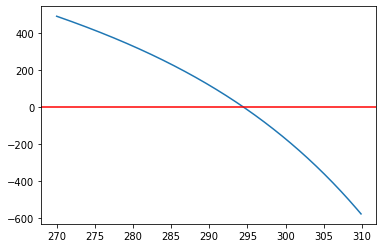

In [31]:
values = []
T_surface = []
for val in np.arange(270,310,0.1):
    Q_0, L_d, L_u, H_0, E_0 = EB_fluxes(val,T_a,f,albedo,G,p,rho,U,z,z0)
    values.append(val)
    T_surface.append(Q_0+L_d-L_u-H_0-E_0)
    
plt.plot(values, T_surface)
plt.axhline(y = 0, color = 'r')

**Task 2**: Now we need to optimize for the surface temperature. Therefore, we need to write a so-called optimization function. In our case the sum of all fluxes should be zero. The SEB depends on the surface temperature. So we have to find the surface temperature which fulfills the condition $SEB(T_0)=Q_0+H_0+E_0=0$. 

In [32]:
def optim_T0(x,T_a,f,albedo,G,p,rho,U_L,z,z0):
    """ Optimization function for surface temperature:
    
    Input: 
    T_0       : Surface temperature, which is optimized [K]
    f         : Relative humdity as fraction, e.g. 0.7 [-]
    albedo    : Snow albedo [-]
    G         : Shortwave radiation [W m^-2]
    p         : Air pressure [hPa]
    rho       : Air denisty [kg m^-3]
    z         : Measurement height [m]
    z_0       : Roughness length [m]
    
    """
    
    Q_0, L_d, L_u, H_0, E_0 = EB_fluxes(x,T_a,f,albedo,G,p,rho,U_L,z,z0)
    
    # Get residual for optimization
    res = np.abs(Q_0+L_d-L_u-H_0-E_0)

    # return the residuals
    return res

In [40]:
T_0 = 283.0   # Surface temperature
T_a = 280.0   # Air temperature 
f = 0.7       # Relative humidity
albedo = 0.3  # albedo
G = 700.0     # Incoming shortwave radiation
rho = 1.1     # Air density
U = 2.0       # Wind velocity
z =  2.0      # Measurement height
z0 = 1e-3     # Roughness length
p = 1013      # Pressure

optim_T0(290,T_a,f,albedo,G,p,rho,U,z,z0)

118.76136146212698

We use the **minimize function** from the scipy module to find the temperature values. 

In [41]:
# Test the SEB function
# Define necessary variables and parameters
T_0 = 283.0   # Surface temperature
T_a = 280.0   # Air temperature 
f = 0.7       # Relative humidity
albedo = 0.3  # albedo
G = 700.0     # Incoming shortwave radiation
rho = 1.1     # Air density
U = 2.0       # Wind velocity
z =  2.0      # Measurement height
z0 = 1e-3     # Roughness length
p = 1013      # Pressure

# Run the function
res = minimize(optim_T0,x0=T_0,args=(T_a,f,albedo,G,p,rho,U,z,z0),bounds=((None,400),), \
                         method='L-BFGS-B',options={'eps':1e-8})

print('Result: {:} \n'.format(res))
print('Optimizes T0: {:.2f}'.format(res.x[0]))

Result:       fun: 4.085183036295348e-08
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([20.17363661])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 154
      nit: 6
     njev: 77
   status: 2
  success: False
        x: array([294.50773708]) 

Optimizes T0: 294.51


The temperature value is stored in the x value of the result dictionary

In [34]:
# Assign optimization result to variable T_0
T_0 = res.x[0]

# Run the function
Q_0, L_d, L_u, H_0, E_0 = EB_fluxes(T_0,T_a,f,albedo,G,p,rho,U,z,z0)

# Print results
print('Surface temperature: {:.2f}'.format(T_0))
print('Global radiation: {:.2f}'.format(Q_0))
print('Longwave down: {:.2f}'.format(L_d))
print('Longwave up: {:.2f}'.format(L_u))
print('Surface heat flux: {:.2f}'.format(H_0))
print('Latent heat flux: {:.2f}'.format(E_0))
print('Energy Balance: {:.2f}'.format(Q_0+L_d-L_u-H_0-E_0))

Surface temperature: 294.51
Global radiation: 490.00
Longwave down: 216.48
Longwave up: 422.28
Surface heat flux: 88.75
Latent heat flux: 195.45
Energy Balance: 0.00
